<a href="https://colab.research.google.com/github/dayothompson/ML_Project/blob/working_branch/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
house_info = pd.read_csv("https://dayotestdb.s3.us-east-2.amazonaws.com/calgary_listings-1-100.csv")
house_info.head()

,price,postal_code,address,bed,full_bath,half_bath,property_area,property_type,latitude,longitude,year_built,years_old,distance_downtown,monthly_payments
0,334786,T3J1K5,116 FALTON WAY NE,3.0,1.0,1.0,1179.0,house,51.102699,-113.942978,1980.0,40.0,11.182732,1447.65
1,469900,T2Z0R3,239 COPPERPOND BAY SE,3.0,2.0,1.0,2136.0,house,50.919753,-113.921865,2011.0,9.0,17.531322,2031.91
2,585000,T3B5X8,25 CRESTHAVEN WAY SW,3.0,2.0,1.0,1556.0,house,51.085292,-114.264517,2002.0,18.0,14.055943,2529.61
3,614900,T3M2J9,28 MAHOGANY PK SE,3.0,3.0,1.0,2166.0,house,50.887413,-113.940111,2017.0,3.0,19.873340,2658.90
4,478800,T3M0X6,117 MAHOGANY HTS SE,4.0,3.0,1.0,1703.0,house,50.903714,-113.934113,2011.0,9.0,18.512596,2070.39


## **Analyzing Data**

In [15]:
house_info = house_info[house_info["price"] < 1000000]
len(house_info)

6631

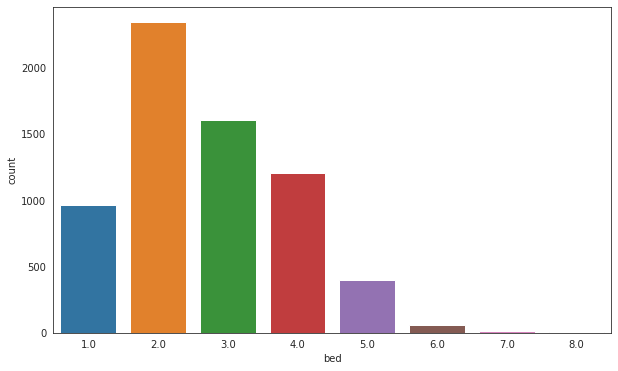

In [16]:
sns.set_style('white')
plt.figure(figsize=(10, 6))
sns.countplot(x="bed", data=house_info)

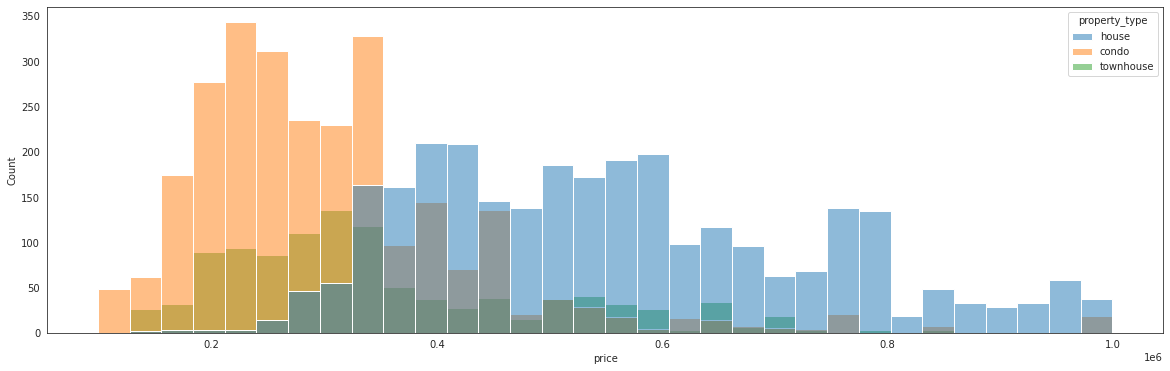

In [17]:
plt.figure(figsize=(20, 6))
sns.histplot(data=house_info, x="price", hue="property_type")

# **Data Wrangling**

In [19]:
house_info.isnull().sum()

price                   0
postal_code             0
address                 0
bed                    44
full_bath              44
half_bath            3784
property_area          13
property_type          41
latitude                0
longitude               0
year_built            812
years_old             812
distance_downtown       0
monthly_payments       64
dtype: int64

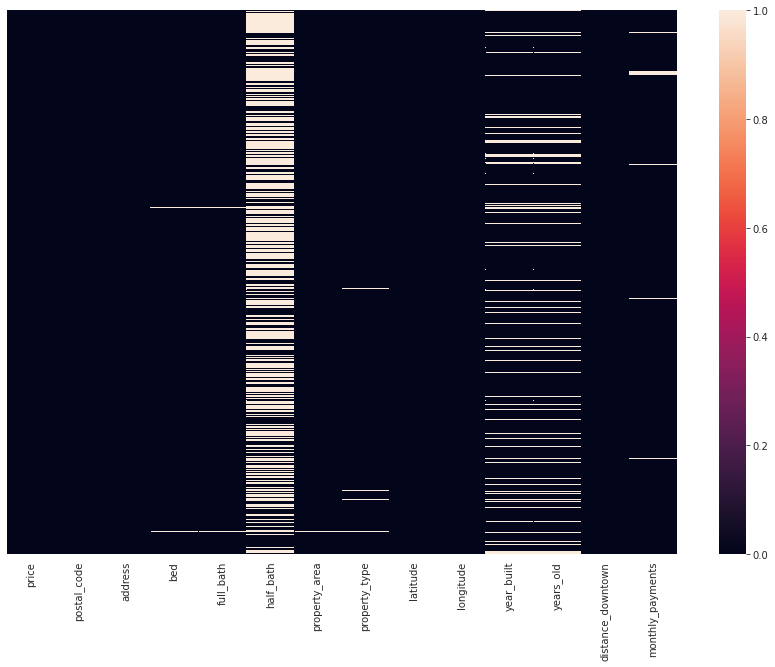

In [20]:
sns.set_style('white')
plt.figure(figsize=(15, 10))
sns.heatmap(data=house_info.isnull(), yticklabels=False)

In [23]:
# Replace nan values with average years_old and 0

house_info['years_old']=house_info['years_old'].replace(np.nan,house_info['years_old'].mean())
house_info['half_bath']=house_info['half_bath'].replace(np.nan,0)
house_info = house_info.dropna(subset=['bed', 'full_bath', 'property_area', 'property_type'])

In [24]:
house_info.isnull().sum()

price                  0
postal_code            0
address                0
bed                    0
full_bath              0
half_bath              0
property_area          0
property_type          0
latitude               0
longitude              0
year_built           802
years_old              0
distance_downtown      0
monthly_payments      58
dtype: int64

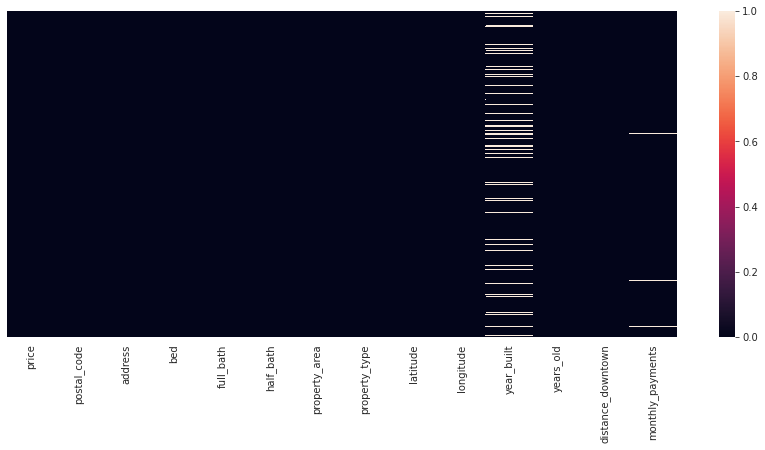

In [25]:
sns.set_style('white')
plt.figure(figsize=(15, 6))
sns.heatmap(data=house_info.isnull(), yticklabels=False)

In [26]:
house_info.head()

,price,postal_code,address,bed,full_bath,half_bath,property_area,property_type,latitude,longitude,year_built,years_old,distance_downtown,monthly_payments
0,334786,T3J1K5,116 FALTON WAY NE,3.0,1.0,1.0,1179.0,house,51.102699,-113.942978,1980.0,40.0,11.182732,1447.65
1,469900,T2Z0R3,239 COPPERPOND BAY SE,3.0,2.0,1.0,2136.0,house,50.919753,-113.921865,2011.0,9.0,17.531322,2031.91
2,585000,T3B5X8,25 CRESTHAVEN WAY SW,3.0,2.0,1.0,1556.0,house,51.085292,-114.264517,2002.0,18.0,14.055943,2529.61
3,614900,T3M2J9,28 MAHOGANY PK SE,3.0,3.0,1.0,2166.0,house,50.887413,-113.940111,2017.0,3.0,19.873340,2658.90
4,478800,T3M0X6,117 MAHOGANY HTS SE,4.0,3.0,1.0,1703.0,house,50.903714,-113.934113,2011.0,9.0,18.512596,2070.39


# **One-hot encoding**

In [27]:
prop_area = pd.get_dummies(house_info["property_type"])
prop_area.head()

,condo,house,townhouse
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0


## **Merge tables**

In [28]:
table_df = pd.concat([house_info, prop_area], axis=1)
table_df.head()

,price,postal_code,address,bed,full_bath,half_bath,property_area,property_type,latitude,longitude,year_built,years_old,distance_downtown,monthly_payments,condo,house,townhouse
0,334786,T3J1K5,116 FALTON WAY NE,3.0,1.0,1.0,1179.0,house,51.102699,-113.942978,1980.0,40.0,11.182732,1447.65,0,1,0
1,469900,T2Z0R3,239 COPPERPOND BAY SE,3.0,2.0,1.0,2136.0,house,50.919753,-113.921865,2011.0,9.0,17.531322,2031.91,0,1,0
2,585000,T3B5X8,25 CRESTHAVEN WAY SW,3.0,2.0,1.0,1556.0,house,51.085292,-114.264517,2002.0,18.0,14.055943,2529.61,0,1,0
3,614900,T3M2J9,28 MAHOGANY PK SE,3.0,3.0,1.0,2166.0,house,50.887413,-113.940111,2017.0,3.0,19.873340,2658.90,0,1,0
4,478800,T3M0X6,117 MAHOGANY HTS SE,4.0,3.0,1.0,1703.0,house,50.903714,-113.934113,2011.0,9.0,18.512596,2070.39,0,1,0


In [29]:
df = table_df[['price', 'bed', 'full_bath', 'half_bath', 'property_area', 'condo',
                 'house', 'townhouse', 'years_old', 'distance_downtown']]
df.head()

,price,bed,full_bath,half_bath,property_area,condo,house,townhouse,years_old,distance_downtown
0,334786,3.0,1.0,1.0,1179.0,0,1,0,40.0,11.182732
1,469900,3.0,2.0,1.0,2136.0,0,1,0,9.0,17.531322
2,585000,3.0,2.0,1.0,1556.0,0,1,0,18.0,14.055943
3,614900,3.0,3.0,1.0,2166.0,0,1,0,3.0,19.873340
4,478800,4.0,3.0,1.0,1703.0,0,1,0,9.0,18.512596


## **Train Data**

In [30]:
X = df.drop('price', axis=1)
y = df['price']

In [31]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [32]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_minmax = MinMaxScaler().fit(X_train)

X_train_minmax = X_minmax.transform(X_train)
X_test_minmax = X_minmax.transform(X_test)



#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X_train_minmax,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
top_features = featureScores.nlargest(10,'Score')
print(top_features)  #print best features

               Specs        Score
5              house  1863.461603
6          townhouse  1863.114090
4              condo  1775.896406
2          half_bath   759.596459
1          full_bath   477.726933
0                bed   373.608484
3      property_area   334.542067
7          years_old   187.920798
8  distance_downtown    74.426896


In [33]:
# Create the model using LinearRegression

from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [34]:
# Fit the model to the training data and calculate the score for the training data

model.fit(X_train_minmax, y_train)
training_score = model.score(X_train_minmax, y_train)

print(f"Training Score: {training_score}")

Training Score: 0.6577056861603694


## **Test Data**

In [35]:
# Calculate the score for the testing data

testing_score = model.score(X_test_minmax, y_test)
print(f"Testing Score: {testing_score}")

Testing Score: 0.6522470471951354


## **Linear Regression Model**

In [36]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [37]:
regr.coef_

array([-1.39228720e+04,  5.97413707e+04, -2.34070121e+04,  1.98481880e+02,
       -3.70607569e+04,  6.88418476e+04, -3.17810906e+04, -2.17376740e+01,
       -1.77794990e+03])

In [38]:
regr.intercept_

113759.2133863396

In [39]:
# Predict the price of a townhouse with the following features

# bed = 3
# full_bath = 2
# half_bath = 0
# property_area = 1500
# years_old = 15
# distance_downtown = 12.554

regr.predict([[3, 2, 0, 1500, 0, 0, 1, 15, 12.554]])

array([434768.62018769])

In [40]:
# Another sample

regr.predict([[3, 3, 0, 1200, 0, 0, 1, 15, 14.2]])

array([432038.92134921])

Text(0.5, 1.0, 'Residual Plot')

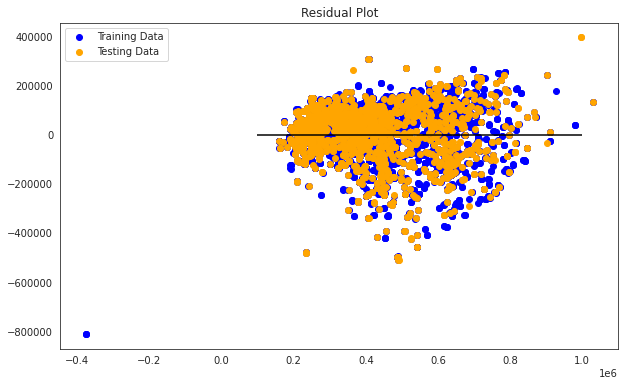

In [41]:
# Plot the Residuals for the Training and Testing data

plt.figure(figsize=(10, 6))
plt.scatter(model.predict(X_train_minmax), model.predict(X_train_minmax) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_minmax), model.predict(X_test_minmax) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")